# Gammapy MWL analysis of Crab data

Author: Fabio Acero, September 2025

## Context and objectives
In this notebook we're going to use the previously generated Crab stacked dataset (1d) from the MAGIC dataset.
Then we're going to load Fermi data of the Crab prepared by Fermipy to make a GeV-TeV fit.

It is also possible in gammapy to load X-ray data from XMM-Newton, Chandra, Swift or NuSTAR but this is beyond the scope of this sole notebook. 
For X-ray examples see : 

- https://github.com/mireianievas/gammapy-ogip-spectra/blob/master/example_nb.ipynb
- https://github.com/gammapy/gammapy-mwl/  (in progress)

**! Warning!**:  The Fermi-LAT analysis shown here is quick and dirty in order to avoid a long notebook. Some aspects such as ednery dispersion or PSF event types are not activated to reduce disk space and complexity.
Do not take the SED, best-fit, etc for granted. 

For a cleaner and better Fermi-LAT analysis have a look at the gammapy tutorial :

https://docs.gammapy.org/2.0/tutorials/data/fermi_lat.html#sphx-glr-tutorials-data-fermi-lat-py

In [1]:
# - basic imports (numpy, astropy, regions, matplotlib)
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import PointSkyRegion, CircleSkyRegion
import matplotlib.pyplot as plt
import logging
import warnings

# - Gammapy's imports
from gammapy.maps import Map, MapAxis, WcsGeom, RegionGeom
from gammapy.data import DataStore, Observation
from gammapy.datasets import SpectrumDataset, Dataset, Datasets
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    PowerLaw2SpectralModel,
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    create_fermi_isotropic_diffuse_model,
    create_crab_spectral_model,
    create_fermi_isotropic_diffuse_model

) 
from gammapy.catalog import SourceCatalog4FGL

# - setting up logging and ignoring warnings
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
warnings.filterwarnings("ignore")

# Loading Fermi data 

We're going to use the pregenerated Fermi files from the fermipy setup.  
To get all the details we're going to use the fermipy yaml config file to get things easier.

All the details of how to load Fermi data into gammapy are given in the Fermi gammapy tutorial : https://docs.gammapy.org/2.0/tutorials/data/fermi_lat.html#sphx-glr-tutorials-data-fermi-lat-py

A tricky thing is how to handle energy dispersion from fermipy files to gammapy datasets. For simplicity this is ignored in the following steps.

In [76]:
from gammapy.datasets import FermipyDatasetsReader

config_file = 'Crab-fermi-config.yaml'  

datasets = FermipyDatasetsReader(config_file, edisp_bins=0).read()
dataset_fermi=datasets[0]
center = dataset_fermi.counts.geom.center_skydir
dataset_fermi.counts.geom

In [77]:
dataset_fermi.counts.smooth(width=0.05*u.deg).plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In Fermi at MeV-GeV, the diffuse from the galactic plane is the main source of photons and cannot be ignored. Here we are loading a cutout of the entire galactic plane model on the Crab region.

In [78]:
modeliso= Models(dataset_fermi.models)
galdiff_file = "./fermi-Crab-analysis/gll_iem_v07_Crab_cutout.fits"
template_diffuse = Map.read(filename=galdiff_file)
template_diffuse.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

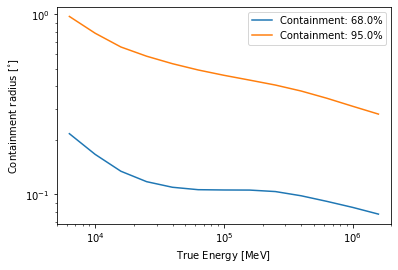

In [79]:
dataset_fermi.psf.plot_containment_radius_vs_energy(fraction=(0.68, 0.95))
plt.yscale('log')
plt.show()

In [80]:
# Background models
# In Fermi the bkg is dominantly the galactic diffuse emission in the plane

template_diffuse = TemplateSpatialModel.read(filename=galdiff_file, normalize=False)
diffuse_iem = SkyModel(spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="iem")


# Defining a spectral model for the Crab
spatial_model = PointSpatialModel(
    lon_0=center.ra, lat_0=center.dec, frame="fk5")

spectral_model = PowerLawSpectralModel(
    index=2.0,
    amplitude=5e-14 * u.Unit("cm-2 s-1 MeV-1"),
    reference=30 * u.GeV
)

model_crab = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="Crab",
)

dataset_fermi.models =   diffuse_iem + modeliso + model_crab 
dataset_fermi.models.freeze(model_type='spatial')
dataset_fermi.models['isotropic_P8R3_SOURCE_V3_v1'].parameters['norm'].frozen=True

dataset_fermi.models

In [81]:
dataset_fermi.mask_fit = dataset_fermi.counts.geom.energy_mask(30 * u.GeV, 1 * u.TeV)


In [82]:
fit = Fit()
result = fit.run(datasets=[dataset_fermi])
result.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6214                       │              Nfcn = 62               │
│ EDM = 8.8e-05 (Goal: 0.0002)     │            time = 1.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_norm      │   1.01    │   0.10    │            │            │         │         │       │
│ 1 │ par_001_index     │   2.08    │   0.04    │            │            │         │         │       │
│ 2 │ par_002_amplitude │   7.78    │   0.34    │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────┐
│                   │      par_000_norm     par_001_index par_002_amplitude │
├───────────────────┼───────────────────────────────────────────────────────┤
│      par_000_norm │           0.00972           -0.0000            -0.001 │
│     par_001_index │           -0.0000            0.0015            0.0103 │
│ par_002_amplitude │            -0.001            0.0103             0.115 │
└───────────────────┴───────────────────────────────────────────────────────┘

In [83]:
energy_edges = dataset_fermi.counts.geom.axes["energy"].edges
fpe_fermi = FluxPointsEstimator(
    energy_edges=energy_edges, source="Crab", n_jobs=4,
)
fp_fermi = fpe_fermi.run(datasets=[dataset_fermi])


We will display these flux points later on

# Reading pre-generated MAGIC dataset and flux point

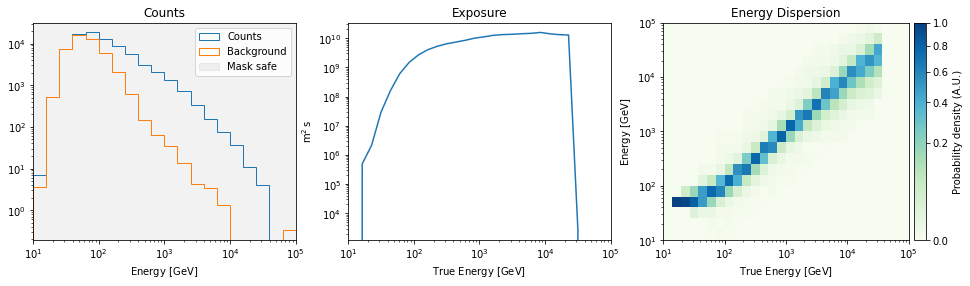

In [11]:
datasets_magic=Datasets.read('Magic-gammapy-dataset/Crab_Magic_stacked_dataset.yaml')
dataset_magic=datasets_magic[0] # we have only one dataset the stacked reduced one
dataset_magic.peek()

In [12]:
logpar_model = LogParabolaSpectralModel(
    amplitude=1e-11 * u.Unit("TeV-1 cm-2 s-1"),
    reference=200 * u.GeV,
    alpha=2.3 * u.Unit(""),
    beta=0.1 * u.Unit(""),
)

# we have to assign the spectral model to a model of the sky
# that in this case will consist of a single source
model = SkyModel(spectral_model=logpar_model, name="Crab-Magic")
dataset_magic.models = model

# declare the energy range to be used for the fitting
dataset_magic.mask_fit = dataset_magic.counts.geom.energy_mask(80 * u.GeV, 20 * u.TeV)

energy_edges = dataset_magic.counts.geom.axes["energy"].edges
fpe_magic = FluxPointsEstimator(
    energy_edges=energy_edges
)
fp_magic = fpe_magic.run(datasets=[dataset_magic])

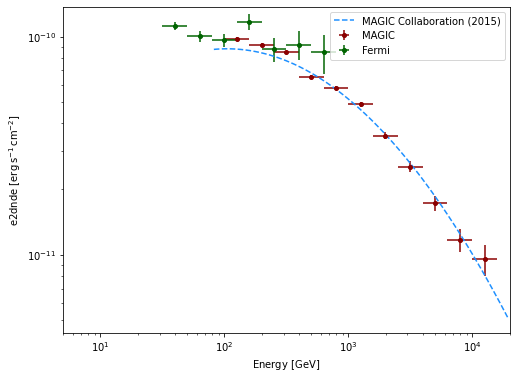

In [84]:
def plot_crab(magic_ref=True):
    fig, ax = plt.subplots(figsize=(8,6))
    
    fp_magic.plot(
        ax=ax,
        color="darkred",
        label="MAGIC",
        sed_type= "e2dnde"
    )
    
    fp_fermi.plot(
        ax=ax,
        color="darkgreen",
        label="Fermi",
        sed_type= "e2dnde"
    )
    
    crab_magic = create_crab_spectral_model("magic_lp")
    if magic_ref:
        crab_magic.plot(
            [80 * u.GeV, 20 * u.TeV],
            ax=ax,
            label="MAGIC Collaboration (2015)",
            color="dodgerblue",
            ls="--",
            sed_type= "e2dnde"    
        )
    ax.set_xlim(5,20e3)

    return ax
    
ax=plot_crab()
plt.legend()
plt.show()

We can notice that MAGIC and Fermi-LAT data are in good agreement except in the TeV range where Fermi calibration is uncertain (it was never meant to be a TeV instrument!).

We also see that the low energy part of Fermi-LAT at 30 GeV is still contaminated by the pulsar component which peaks around a few GeV.



# Now doing a joint fit with both Fermi + MAGIC data

In [85]:
# Now changing the model in the Fermi dataset to a LogParabola
model_crab = SkyModel(
    spatial_model=spatial_model,
    spectral_model=logpar_model,
    name="Crab-Fermi",
)

dataset_fermi.mask_fit = dataset_fermi.counts.geom.energy_mask(30 * u.GeV, 1 * u.TeV)
dataset_fermi.models =  diffuse_iem + modeliso + model_crab 
dataset_fermi.models

In [86]:
dataset_magic.models

In [87]:
fit = Fit()
result_joint = fit.run(datasets=[dataset_fermi, dataset_magic])
result_joint.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6247                       │              Nfcn = 103              │
│ EDM = 8.03e-05 (Goal: 0.0002)    │            time = 2.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_norm      │   1.01    │   0.10    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   1.436   │   0.012   │            │            │         │         │       │
│ 2 │ par_002_alpha     │   2.218   │   0.011   │            │            │         │         │       │
│ 3 │ par_003_beta      │    84     │     5     │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬─────────────────────────────────────────────────────────────────────────┐
│                   │      par_000_norm par_001_amplitude     par_002_alpha      par_003_beta │
├───────────────────┼─────────────────────────────────────────────────────────────────────────┤
│      par_000_norm │           0.00976          -0.01e-3          -0.03e-3             0.013 │
│ par_001_amplitude │          -0.01e-3          0.000137           0.01e-3          21.25e-3 │
│     par_002_alpha │          -0.03e-3           0.01e-3          0.000111         -39.73e-3 │
│      par_003_beta │             0.013          21.25e-3         -39.73e-3              28.5 │
└───────────────────┴─────────────────────────────────────────────────────────────────────────┘

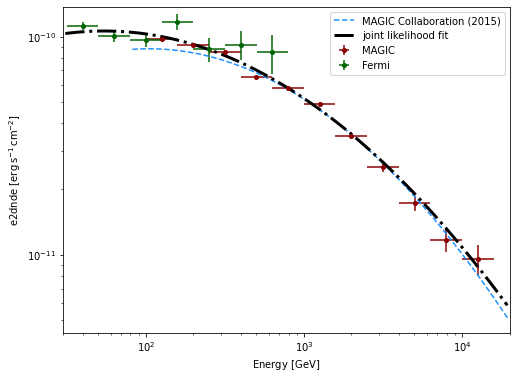

In [88]:
ax=plot_crab()

ax.set_xlim(30,20e3)

logpar_model.plot(
    [30 * u.GeV, 20 * u.TeV],
    color="k",
    ls="-.",
    lw=3,
    sed_type="e2dnde",
    label="joint likelihood fit",
    
)

plt.legend()
plt.show()


**!Warning!**

Note that this joint fit has not been done on the SED flux points but on the DL3/DL4 raw data directly. This allows to have the full IRF description and fitting the background source at the same time. 
For example for Fermi when fitting SED the correlation between the galactic diffuse and the fitted model is lost while it is preserved here.

The fit was performed one side on the 3d Fermi dataset and on the other side on the MAGIC 1D `SpectrumDatasetONOFF`.

# Fitting on flux points 
The classic procedure to fit a spectral model from multiple telescopes is to fit a spectral model on flux points. This has several limitations in particular for faint sources (not the case here).  

In [89]:
from gammapy.datasets import FluxPointsDataset

datasets_fp_fermi = FluxPointsDataset(data=fp_fermi, name='FP Fermi')
datasets_fp_magic = FluxPointsDataset(data=fp_magic, name='FP MAGIC')

logpar_model_fp = LogParabolaSpectralModel(
    amplitude=1e-11 * u.Unit("TeV-1 cm-2 s-1"),
    reference=200 * u.GeV,
    alpha=2.3 * u.Unit(""),
    beta=0.1 * u.Unit(""),
)

model_crab = SkyModel(
    spatial_model=spatial_model,
    spectral_model=logpar_model_fp,
    name="Crab-Fermi",
)

datasets_fp_fermi.models=SkyModel(spectral_model=logpar_model_fp, name='Crab_fp_fermi')
datasets_fp_magic.models=SkyModel(spectral_model=logpar_model_fp, name='Crab_fp_magic')


In [90]:
result_fp = fit.run(datasets=[datasets_fp_fermi,datasets_fp_magic])
result_fp.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.98                      │              Nfcn = 300              │
│ EDM = 8.5e-05 (Goal: 0.0002)     │            time = 1.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_amplitude │   143.3   │    1.2    │            │            │         │         │       │
│ 1 │ par_001_alpha     │   2.219   │   0.011   │            │            │         │         │       │
│ 2 │ par_002_beta      │   0.86    │   0.05    │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────┐
│                   │ par_000_amplitude     par_001_alpha      par_002_beta │
├───────────────────┼───────────────────────────────────────────────────────┤
│ par_000_amplitude │              1.33           1.48e-3            0.0143 │
│     par_001_alpha │           1.48e-3          0.000117          -0.41e-3 │
│      par_002_beta │            0.0143          -0.41e-3           0.00262 │
└───────────────────┴───────────────────────────────────────────────────────┘

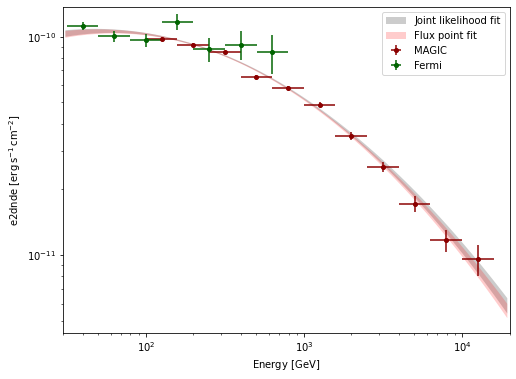

In [94]:
ax=plot_crab(magic_ref=False)

ax.set_xlim(30,20e3)

logpar_model.plot_error(
    [30 * u.GeV, 20 * u.TeV],
    facecolor="k",
    sed_type="e2dnde",
    label="Joint likelihood fit",
    
)

logpar_model_fp.plot_error(
    [30 * u.GeV, 20 * u.TeV],
    facecolor="r",
    sed_type="e2dnde",
    label="Flux point fit",
    
)

plt.legend()
plt.show()


We can see that for this specific case of a bright source with no upper-limit, the two methods give very similar results. 
However when several energy bins give a non-detection, the results can differ significantly.